# Price Prediction Models Part 2: Style

From SimpleModel and model_jared_1, we found that simply using a pretrained model is not enough for predicting art prices. Here, we try another approach using elements of style transfer.

Instead of using an image as input to our model, we use its "styles". From a simple model like VGG19, we can extract styles from specific intermediate layers, which will be fed as input to our model. 

## TLDR
The test loss is about the same as training a resnet model. Looking back, this result should be expected since in a way, what this method does is just slice up a VGG model and append a ResNet model after it. 

In [ ]:
import torch, torchvision, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import torchvision.transforms as transforms, torchvision.models as models
import matplotlib.pyplot as plt
import PIL, IPython
import pathlib
import pandas as pd
import math
import random
from tqdm.auto import tqdm
from collections import OrderedDict
plt.style.use('dark_background')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda')

In [ ]:
models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Modified from style-xfer.ipynb
class FeatureExtractor(nn.Module):
    def __init__(self, feat_layers):
        super(FeatureExtractor, self).__init__()
        self.feat_layers = feat_layers
        self.vgg_backbone = models.vgg19(pretrained=True).features[:max(feat_layers)+1]

    def forward(self, xs):
        feats = []
        for n, layer in enumerate(self.vgg_backbone):
            xs = layer(xs)
            if (n in self.feat_layers):
                feats.append(xs)
        return feats

In [ ]:
dataset_dir = "/content/drive/My Drive/CPEN 291/project/data/"

In [ ]:
feats = FeatureExtractor([3, 8, 17, 26]).to(device).eval() 


## Our dataset

In [ ]:
# Copied from object_detection.ipynb
def read_img(fn):
    # Resize so that all tensors made are of the same shape
    xform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), torchvision.transforms.ToTensor()])
    #xform = transforms.ToTensor()
    img = PIL.Image.open(fn)
    img = img.convert('RGB')
    return xform(img).requires_grad_(False).unsqueeze(0) # batch

In [ ]:
def feat_xform(fts):
  # original shape = (1, channels (see VGG model), height, width)
  # Assuming that we are using VGG19
  # Turn it into 1D tensors
  f0 = fts[0].view(-1, 64*224*224)[None, :, :]
  f1 = fts[1].view(-1, 128*112*112)[None, :, :]
  f2 = fts[2].view(-1, 256*56*56)[None, :, :]
  f3 = fts[3].view(-1, 512*28*28)[None, :, :]
  # Shirnk as neccessary, so their sizes are the same
  avgpool0 = nn.AvgPool1d(kernel_size=8, stride=8)
  avgpool1 = nn.AvgPool1d(kernel_size=4, stride=4)
  avgpool2 = nn.AvgPool1d(kernel_size=2, stride=2)
  #fe0 = f0[0]
  fe0 = avgpool0(f0)
  fe0 = torch.squeeze(fe0)
  #fe1 = f1[0].repeat(2)
  fe1 = avgpool1(f1)
  fe1 = torch.squeeze(fe1)
  #fe2 = f2[0].repeat(4)
  fe2 = avgpool2(f2)
  fe2 = torch.squeeze(fe2)
  #fe3 = f3[0].repeat(8)
  fe3 = f3[0]
  fe3 = torch.squeeze(fe3)
  # Stack them
  final_feats = torch.stack([fe0, fe1, fe2, fe3])
  return final_feats
  

In [ ]:
# Modified from object_detection.ipynb
# Requires read_img and feat_xform
class PricePredictionDataset:
    def __init__(self, root_dir, use_random=False):
        root_dir = pathlib.Path(root_dir).resolve()
        self.root_dir = root_dir

        if (use_random):
          self.labels_f = pd.read_csv(root_dir / 'all_labels_random.csv')
        else:
          self.labels_f = pd.read_csv(root_dir / 'all_labels.csv')

        def get_price(fn):
            fn = str(fn).rsplit('/', 1)[-1]
            row = self.labels_f.loc[self.labels_f['name'] == fn]
            index = row.index[0]
            return math.log(row['price'][index]) # log because we are scientists

        self.fns_labels = [(imgfn, get_price(imgfn))
                           for imgfn in sorted(root_dir.glob('*.jpg'))]

    def __len__(self):
        return len(self.fns_labels)

    def getitem_helper(self, i):
        if torch.is_tensor(i):
            i = i.item()
        imgfn, label = self.fns_labels[i]
        img = read_img(imgfn).to(device)
        ret_img = PIL.Image.open(imgfn)
        img_feats = [f.detach() for f in feats(img)] # Perform style extraction
        img_feats = feat_xform(img_feats);
        return (img_feats, label, ret_img)

    def __getitem__(self, i):
      img_feats, label, _ = self.getitem_helper(i)
      return (img_feats, label)
      

In [ ]:
# Modified from object_detection.ipynb
def show_img_price(sample):
    img_feats, price, img = sample
    if torch.is_tensor(img):
        img = img.cpu().squeeze()
    plt.imshow(img)
    plt.title(math.e**price, color='w') # add color='w' arg if using a dark background
    plt.axis('off')

4498


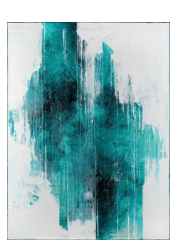

In [ ]:
#dataset_full= PricePredictionDataset(dataset_dir, True)#, transform=xform)
dataset_full= PricePredictionDataset(dataset_dir, False)#, transform=xform)
print(len(dataset_full))
show_img_price(dataset_full.getitem_helper(103))

In [ ]:
fts, price = dataset_full[100]
print(fts)
print(fts.shape)

tensor([[ 0.0129,  0.0000,  0.0000,  ...,  0.1303,  0.1234,  0.1433],
        [ 0.3645,  0.5458,  0.4794,  ...,  1.5473,  0.9542,  1.3641],
        [ 5.7988,  3.8919,  3.1796,  ..., 11.3976, 11.0719,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')
torch.Size([4, 401408])


### Loaders

In [ ]:
n_all= len(dataset_full)
n_used= int(1 * n_all)
n_train= int(0.8 * n_used)
n_test= n_used- n_train
rng= torch.Generator().manual_seed(1910)
dataset_train, dataset_test, _ = torch.utils.data.random_split(dataset_full, [n_train, n_test, n_all-n_train-n_test], rng)
len(dataset_train), len(dataset_test)

(3598, 900)

In [ ]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=False)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

## Our model

Things I tried:
1. Having an input size of 4 * 3211264. It required too much ram
2. Having an input size of 4 * 401408. I could train it once on every restart of the runtime, since it still required a lot of ram. I used a higher learning rate in hopes of trainging the model faster, but it resulted in very high test and train loss. 
3. Same as 2 but with a lower learning rate. The model test loss converged at around 1.17, same as using a pretrained resnet18 model.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(4, 64, kernel_size=8, stride=2, padding=0, dilation=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, ceil_mode=True)
        self.layer1 = nn.Sequential(OrderedDict({
            'conv1': nn.Conv1d(64, 64, kernel_size=5, stride=1),
            'bn1': nn.BatchNorm1d(64),
            'relu1': nn.ReLU(inplace=True),
            'conv2': nn.Conv1d(64, 64, kernel_size=5, stride=1),
            'bn2': nn.BatchNorm1d(64),
            'downsample': nn.Sequential(
                nn.Conv1d(64, 64, kernel_size=5, stride=5),
                nn.BatchNorm1d(64)
            ),
            'conv3': nn.Conv1d(64, 64, kernel_size=5, stride=1),
            'bn3': nn.BatchNorm1d(64),
            'relu2': nn.ReLU(inplace=True),
            'conv4': nn.Conv1d(64, 64, kernel_size=5, stride=1),
            'bn4': nn.BatchNorm1d(64)
        }))
        self.layer2 = nn.Sequential(OrderedDict({
            'conv1': nn.Conv1d(64, 128, kernel_size=5, stride=1),
            'bn1': nn.BatchNorm1d(128),
            'relu1': nn.ReLU(inplace=True),
            'conv2': nn.Conv1d(128, 128, kernel_size=5, stride=1),
            'bn2': nn.BatchNorm1d(128),
            'downsample': nn.Sequential(
                nn.Conv1d(128, 128, kernel_size=5, stride=5),
                nn.BatchNorm1d(128)
            ),
            'conv3': nn.Conv1d(128, 128, kernel_size=5, stride=1),
            'bn3': nn.BatchNorm1d(128),
            'relu2': nn.ReLU(inplace=True),
            'conv4': nn.Conv1d(128, 128, kernel_size=5, stride=1),
            'bn4': nn.BatchNorm1d(128)
        }))
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(in_features=128, out_features=32),
            'relu1': torch.nn.ReLU(),
            'lin2': nn.Linear(in_features=32, out_features=1)
        }))
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.layer1[0].weight)
        torch.nn.init.xavier_uniform_(self.layer1[3].weight)
        torch.nn.init.xavier_uniform_(self.layer1[6].weight)
        torch.nn.init.xavier_uniform_(self.layer1[9].weight)
        torch.nn.init.xavier_uniform_(self.layer2[0].weight)
        torch.nn.init.xavier_uniform_(self.layer2[3].weight)
        torch.nn.init.xavier_uniform_(self.layer2[6].weight)
        torch.nn.init.xavier_uniform_(self.layer2[9].weight)
        torch.nn.init.xavier_uniform_(self.fc[0].weight)
        torch.nn.init.xavier_uniform_(self.fc[2].weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
model = Net()
model.to(device)

Net(
  (conv1): Conv1d(4, 64, kernel_size=(8,), stride=(2,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (layer1): Sequential(
    (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv1d(64, 64, kernel_size=(5,), stride=(5,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv4): Co

### Criterion, Optimizer, Scheduler

In [ ]:
criterion = torch.nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.5)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #, weight_decay=0.1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)

### Helper for training and testing

In [ ]:
def run_test(model, criterion, no_preds=False):
    nsamples_test = len(dataset_test)
    loss = 0
    preds = []
    model.eval()
    with torch.no_grad():
        for samples, labels in loader_test:
            samples = samples.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outs = model(samples)
            if not no_preds:
                preds += outs.cpu().unbind()
            loss += criterion(outs, labels) * samples.size(0)
    return loss / nsamples_test, preds

def run_train(model, criterion, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar = 0
    model.train()
    lossnan = 0
    with torch.enable_grad():
        for samples, labels in tqdm(loader_train, desc='iters', leave=False):
            samples = samples.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            opt.zero_grad()
            outs = model(samples)
            loss = criterion(outs, labels)
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * samples.size(0)
            if (math.isnan(loss.item())):
              lossnan += 1
    sched.step()
    print(lossnan)
    return loss_sofar / nsamples_train

def run_all(model, criterion, optimizer, scheduler, n_epochs):
    for epoch in tqdm(range(n_epochs), desc='epochs'):
        loss_train = run_train(model, criterion, optimizer, scheduler)
        loss_test, _ = run_test(model, criterion, no_preds=True)
        tqdm.write(f"epoch {epoch+1}: train loss {loss_train:.4f}, test loss {loss_test:.4f}")
    return loss_test

# Use L1loss to train the model until the loss is low enough to use MSEloss # not used
def marathon(model, criterion0, criterion, optimizer, scheduler, n_epochs):
    crit = criterion0
    for epoch in tqdm(range(n_epochs), desc='epochs'):
        loss_train = run_train(model, crit, optimizer, scheduler)
        loss_test, _ = run_test(model, crit, no_preds=True)
        tqdm.write(f"epoch {epoch+1}: train loss {loss_train:.4f}, test loss {loss_test:.4f}")
        if (loss_train < 0.1 and loss_test < 0.1):
          crit = criterion
    return loss_test


In [ ]:
run_all(model, criterion, optimizer, scheduler, 40)

0
epoch 1: train loss 1.1061, test loss 1.1904


0
epoch 2: train loss 1.1046, test loss 1.1910


0
epoch 3: train loss 1.1035, test loss 1.1954


0
epoch 4: train loss 1.1023, test loss 1.2061


0
epoch 5: train loss 1.1006, test loss 1.2103


0
epoch 6: train loss 1.0991, test loss 1.2237


KeyboardInterrupt: ignored

model | input | criterion | optimizer | scheduler | train loss | test loss
--- | --- | --- | --- | --- |--- | --- 
v1 | 4 * 3200000 | MSELoss | SGD, lr=0.05, m=0.1 | StepLR size=5, gamma=0.7 | nan | nan
v1 (20 iter) | 4 * 400000 | MSELoss | SGD, lr=0.01, m=0.9 | multiStepLR, milestone=30,80 , gamma=0.1 | 1.18 | 1.18
v1 (40 iter) | 4 * 400000 | MSELoss | SGD, lr=0.01, m=0.9 | multiStepLR, milestone=30,80 , gamma=0.1 | 1.13 | 1.165
v1 (60 iter) | 4 * 400000 | MSELoss | SGD, lr=0.01, m=0.9 | multiStepLR, milestone=30,80 , gamma=0.1 | 1.10 | 1.177

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/CPEN 291/project/model_jared_2_v1_20iter.pth')

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/CPEN 291/project/model_jared_2_v1_40iter.pth')
torch.save(optimizer.state_dict(), '/content/drive/My Drive/CPEN 291/project/optim_jared_2_v1_40iter.pth')

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/CPEN 291/project/model_jared_2_v1_60iter.pth')
torch.save(optimizer.state_dict(), '/content/drive/My Drive/CPEN 291/project/optim_jared_2_v1_60iter.pth')
torch.save(scheduler.state_dict(), '/content/drive/My Drive/CPEN 291/project/sched_jared_2_v1_60iter.pth')

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/CPEN 291/project/model_jared_2_v1_100iter.pth')
torch.save(optimizer.state_dict(), '/content/drive/My Drive/CPEN 291/project/optim_jared_2_v1_100iter.pth')
torch.save(scheduler.state_dict(), '/content/drive/My Drive/CPEN 291/project/sched_jared_2_v1_100iter.pth')

In [ ]:
model